In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the path to your image directories
base_dir = "/content/drive/MyDrive/terrain dataset"
grass_dir = os.path.join(base_dir, "Grassy_Terrain")
marshy_dir = os.path.join(base_dir, "Marshy_Terrain")
rocky_dir = os.path.join(base_dir, "Rocky_Terrain")
sandy_dir = os.path.join(base_dir, "Sandy_Terrain")
other_dir = os.path.join(base_dir, "Other_Image")

In [ ]:
# Function to load and preprocess images
def load_and_preprocess_image(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):  # Assuming images are in JPG format
            img_path = os.path.join(directory, filename)
            img = load_img(img_path, target_size=(224, 224))  # Update target size to (299, 299)
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)  # Preprocess for Xception
            images.append(img_array)
            labels.append(label)

    return np.array(images), np.array(labels)

In [ ]:
# Load and preprocess images from each directory
grass_images, grass_labels = load_and_preprocess_image(grass_dir, "Grassy_Terrain")
marshy_images, marshy_labels = load_and_preprocess_image(marshy_dir, "Marshy_Terrain")
rocky_images, rocky_labels = load_and_preprocess_image(rocky_dir, "Rocky_Terrain")
sandy_images, sandy_labels = load_and_preprocess_image(sandy_dir, "Sandy_Terrain")
other_images, other_labels = load_and_preprocess_image(other_dir, "Other_Image")

In [ ]:
# Combine data from all categories
all_images = np.concatenate([grass_images, marshy_images, rocky_images, sandy_images, other_images], axis=0)
all_labels = np.concatenate([grass_labels, marshy_labels, rocky_labels, sandy_labels, other_labels], axis=0)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(all_labels)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels_encoded, test_size=0.2, random_state=42)

In [ ]:
# Create the Xception model as a feature extractor
input_tensor = layers.Input(shape=(224, 224, 3))
base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)
base_model.trainable = False

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
# Build the final model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(5, activation='softmax')(x)

final_model = models.Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compile the model
final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = final_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
50/50 [==============================] - 272s 5s/step - loss: 0.5560 - accuracy: 0.7938 - val_loss: 0.3039 - val_accuracy: 0.8794
Epoch 2/10
50/50 [==============================] - 298s 6s/step - loss: 0.2689 - accuracy: 0.9107 - val_loss: 0.2373 - val_accuracy: 0.9095
Epoch 3/10
50/50 [==============================] - 267s 5s/step - loss: 0.2063 - accuracy: 0.9302 - val_loss: 0.2366 - val_accuracy: 0.9121
Epoch 4/10
50/50 [==============================] - 300s 6s/step - loss: 0.1618 - accuracy: 0.9459 - val_loss: 0.2106 - val_accuracy: 0.9246
Epoch 5/10
50/50 [==============================] - 298s 6s/step - loss: 0.1371 - accuracy: 0.9566 - val_loss: 0.2140 - val_accuracy: 0.9296
Epoch 6/10
50/50 [==============================] - 299s 6s/step - loss: 0.1236 - accuracy: 0.9610 - val_loss: 0.2054 - val_accuracy: 0.9246
Epoch 7/10
50/50 [==============================] - 270s 5s/step - loss: 0.0915 - accuracy: 0.9711 - val_loss: 0.2133 - val_accuracy: 0.9246
Epoch 8/10
50

In [ ]:
final_model.save('/content/drive/MyDrive/Save Model/terrain.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


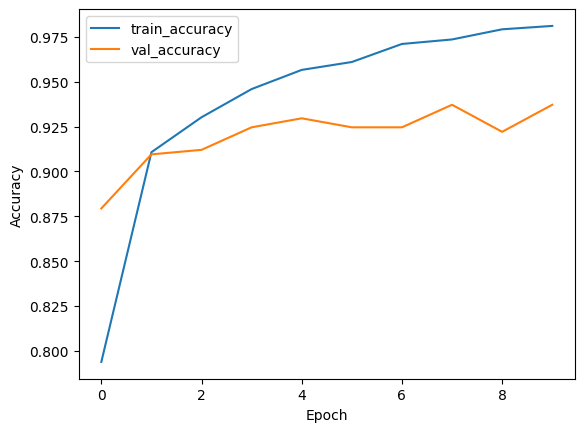

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

13/13 [==============================] - 59s 5s/step


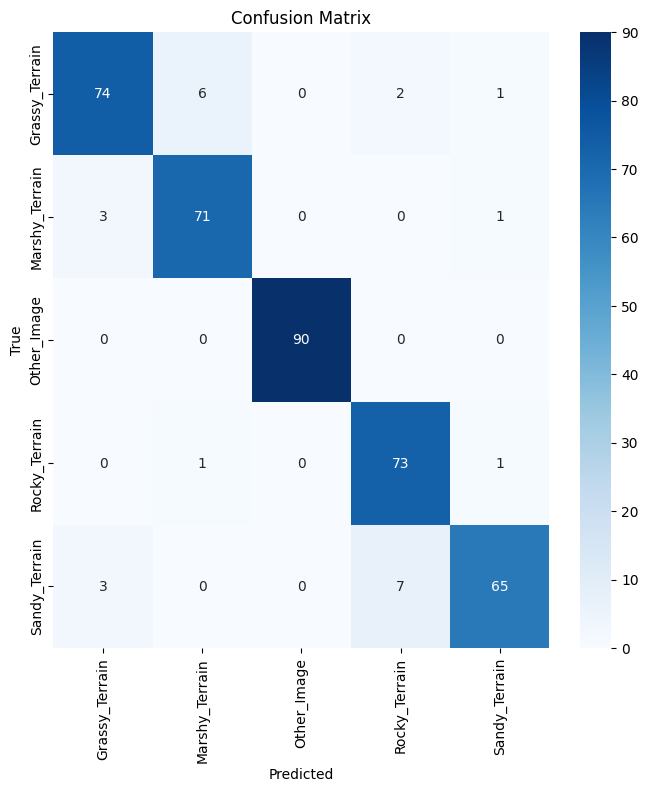

                precision    recall  f1-score   support

Grassy_Terrain       0.93      0.89      0.91        83
Marshy_Terrain       0.91      0.95      0.93        75
   Other_Image       1.00      1.00      1.00        90
 Rocky_Terrain       0.89      0.97      0.93        75
 Sandy_Terrain       0.96      0.87      0.91        75

      accuracy                           0.94       398
     macro avg       0.94      0.94      0.94       398
  weighted avg       0.94      0.94      0.94       398



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt



# Predict classes for the test set
y_pred = final_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
class_names = label_encoder.classes_
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print(classification_report(y_test, y_pred_classes, target_names=class_names))


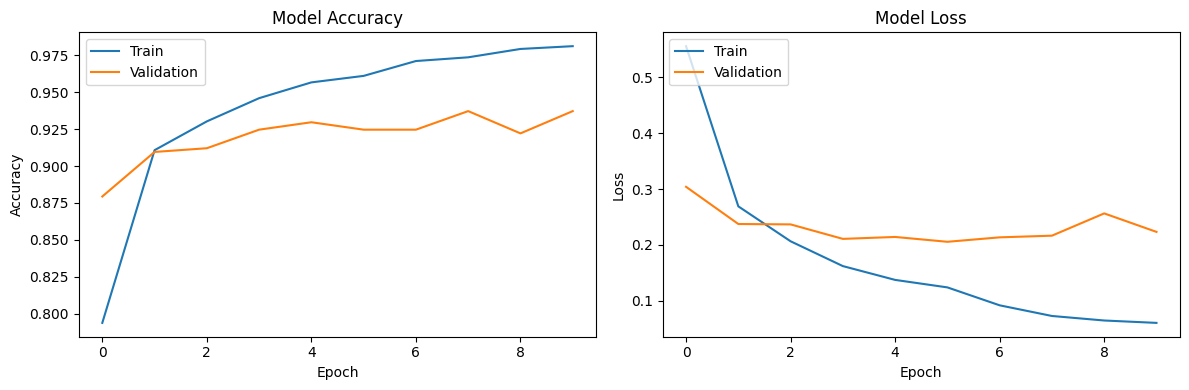

In [ ]:
import matplotlib.pyplot as plt





# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Define class labels used during training
training_class_labels = ['Grassy_Terrain', 'Marshy_Terrain', 'Rocky_Terrain', 'Sandy_Terrain', 'Other_Image']

# Define class labels used during prediction
class_labels = ['Grassy_Terrain', 'Marshy_Terrain', 'Other_Image', 'Rocky_Terrain', 'Sandy_Terrain']

# Load the trained model for terrain classification
model = load_model('/content/drive/MyDrive/Save Model/terrain.h5')

# Load and preprocess the new image
img_path = '/content/drive/MyDrive/terrain dataset/Other_Image/Other_image (503).jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Update target size to (224, 224)
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make predictions for terrain classification
predictions = model.predict(img_array)

# Print relevant information for debugging
print("Shape of predictions array:", predictions.shape)
print("Predictions array:", predictions)

# Map predicted probabilities to class labels
predicted_class_index = np.argmax(predictions)

# Print additional information for debugging
print("Predicted class index:", predicted_class_index)

# Ensure the predicted class index is within the valid range
if 0 <= predicted_class_index < len(class_labels):
    predicted_class = class_labels[predicted_class_index]
    print("Predicted class:", predicted_class)
else:
    print("Error: Predicted class index is outside the valid range.")


1/1 [==============================] - 1s 736ms/step
Shape of predictions array: (1, 5)
Predictions array: [[7.0198006e-08 1.9853305e-05 9.9997973e-01 1.4626362e-07 2.5470541e-07]]
Predicted class index: 2
Predicted class: Other_Image


In [3]:
import os

# Set the path to your image directories
base_dir = "/content/drive/MyDrive/terrain dataset"
grass_dir = os.path.join(base_dir, "Grassy_Terrain")
marshy_dir = os.path.join(base_dir, "Marshy_Terrain")
rocky_dir = os.path.join(base_dir, "Rocky_Terrain")
sandy_dir = os.path.join(base_dir, "Sandy_Terrain")
other_dir = os.path.join(base_dir, "Other_Image")

# Function to count the number of files in a directory
def count_files_in_directory(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

# Print the number of images in each class
print("Number of images in Grassy_Terrain:", count_files_in_directory(grass_dir))
print("Number of images in Marshy_Terrain:", count_files_in_directory(marshy_dir))
print("Number of images in Rocky_Terrain:", count_files_in_directory(rocky_dir))
print("Number of images in Sandy_Terrain:", count_files_in_directory(sandy_dir))
print("Number of images in Other_Image:", count_files_in_directory(other_dir))


Number of images in Grassy_Terrain: 395
Number of images in Marshy_Terrain: 394
Number of images in Rocky_Terrain: 400
Number of images in Sandy_Terrain: 400
Number of images in Other_Image: 400
